Using device: cuda


C:\Users\park9\AppData\Local\Temp\ipykernel_39756\235232063.py:225: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)


Split results (by sample count):
  New Train set: 5441 samples
  New Test set:  2332 samples


🔬 Ablation 1: Base (n_layers=3, Multi-scale, No SE)
  - Parameters: 73,292
[Model 1 (Base, L=3)] Epoch 25/50: Train Acc=99.50%, Test F1=0.9676, Test Acc=96.91% (Best F1: 0.9747, Best Acc: 97.64%)
[Model 1 (Base, L=3)] Epoch 50/50: Train Acc=99.82%, Test F1=0.9728, Test Acc=97.47% (Best F1: 0.9775, Best Acc: 97.81%)

🔬 Ablation 2: + SE Block
  - Parameters: 74,904
[Model 2 (+SE)] Epoch 25/50: Train Acc=99.47%, Test F1=0.9748, Test Acc=97.81% (Best F1: 0.9799, Best Acc: 98.20%)
[Model 2 (+SE)] Epoch 50/50: Train Acc=99.78%, Test F1=0.9774, Test Acc=98.07% (Best F1: 0.9810, Best Acc: 98.28%)

🔬 Ablation 3: + SE Block + Physics Loss
  - Parameters: 77,083
[Physics*] Epoch 025/50 | Train Acc=99.63% | CE=0.3159 | Phys=0.5195 (λ_total=0.050) | Total=0.3419 || Test F1=0.9861 | Test Acc=98.76% (Best F1=0.9867, Best Acc=98.84%)
[Physics*] Epoch 050/50 | Train Acc=99.83% | CE=0.3070 | Phys=0.5188 (λ_tot

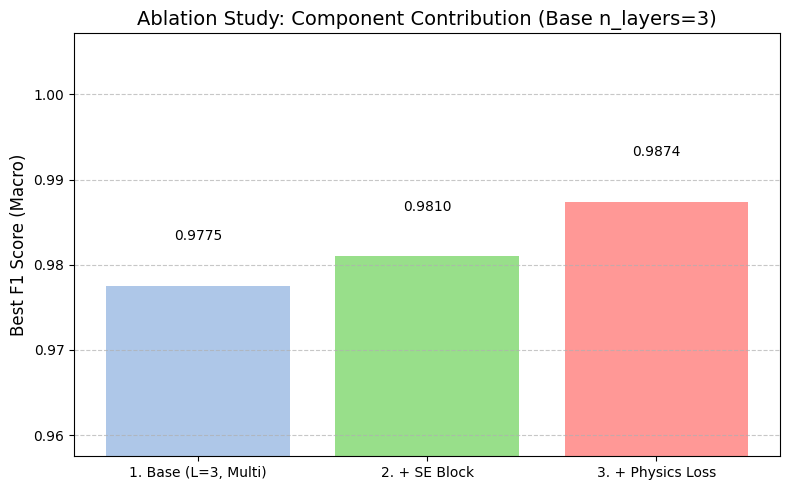

In [1]:
import os
import re
import numpy as np
import pandas as pd 
import glob        
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from pathlib import Path
import time
import random
from collections import deque
import matplotlib.pyplot as plt    
from sklearn.metrics import f1_score    
from sklearn.preprocessing import StandardScaler

# ========================
# SEED 고정 함수
# ========================
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # CUDA 11+

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=False)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

# ========================
# PAMAP2 데이터 로드 
# ========================
def create_pamap2_windows(df: pd.DataFrame, window_size: int, step_size: int):
    """
    subject별로 timestamp 순서대로 전체 시계열을 따라가며 슬라이딩 윈도우 생성.
    한 윈도우의 라벨은 마지막 프레임의 activityID.
    마지막 라벨이 0(Null/기타) 이면 그 윈도우는 버린다.

    Returns:
        X:          (N, C, T) float32
        y:          (N,) int64  (0..11로 리맵된 레이블)
        subj_ids:   (N,) int64
        label_names:list[str] 길이 12, new_index -> human-readable
    """

    # 사용할 피처들 (orientation*, heartrate, *_Temperature 등은 제외)
    feature_cols = [
        # hand
        "handAcc16_1","handAcc16_2","handAcc16_3",
        "handAcc6_1","handAcc6_2","handAcc6_3",
        "handGyro1","handGyro2","handGyro3",
        "handMagne1","handMagne2","handMagne3",
        # chest
        "chestAcc16_1","chestAcc16_2","chestAcc16_3",
        "chestAcc6_1","chestAcc6_2","chestAcc6_3",
        "chestGyro1","chestGyro2","chestGyro3",
        "chestMagne1","chestMagne2","chestMagne3",
        # ankle
        "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3",
        "ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
        "ankleGyro1","ankleGyro2","ankleGyro3",
        "ankleMagne1","ankleMagne2","ankleMagne3",
    ]

    # PAMAP2 실제 activityID들 중 우리가 쓰는 12개 클래스만 남김
    # 순서 고정: 이 순서가 new class index 0..11이 된다.
    ORDERED_IDS = [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]

    # 원본 activityID -> new index(0..11)
    old2new = {
        1: 0,   # Lying
        2: 1,   # Sitting
        3: 2,   # Standing
        4: 3,   # Walking
        5: 4,   # Running
        6: 5,   # Cycling
        7: 6,   # Nordic walking
        12: 7,  # Ascending stairs
        13: 8,  # Descending stairs
        16: 9,  # Vacuum cleaning
        17: 10, # Ironing
        24: 11, # Rope jumping
    }

    # new index -> 사람이 읽는 이름
    label_names = [
        "Lying",              # 0 -> orig 1
        "Sitting",            # 1 -> orig 2
        "Standing",           # 2 -> orig 3
        "Walking",            # 3 -> orig 4
        "Running",            # 4 -> orig 5
        "Cycling",            # 5 -> orig 6
        "Nordic walking",     # 6 -> orig 7
        "Ascending stairs",   # 7 -> orig 12
        "Descending stairs",  # 8 -> orig 13
        "Vacuum cleaning",    # 9 -> orig 16
        "Ironing",            # 10 -> orig 17
        "Rope jumping",       # 11 -> orig 24
    ]

    X_list = []
    y_list = []
    subj_list = []

    # subject별로 끊어서 시간 순 정렬 후 슬라이딩 윈도우
    for subj_id, g in df.groupby("subject_id"):
        # 시간순 정렬
        if "timestamp" in g.columns:
            g = g.sort_values("timestamp")
        else:
            g = g.sort_index()

        data_arr  = g[feature_cols].to_numpy(dtype=np.float32)   # (L, C)
        label_arr = g["activityID"].to_numpy(dtype=np.int64)     # (L,)
        L = data_arr.shape[0]

        start = 0
        while start + window_size <= L:
            end = start + window_size

            last_label_orig = int(label_arr[end - 1])

            # 0 = "other / null" → 버림
            if last_label_orig == 0:
                start += step_size
                continue

            # 우리가 쓰는 12개 클래스에 없는 라벨이면 버림
            if last_label_orig not in old2new:
                start += step_size
                continue

            # 윈도우 추출
            window_ct = data_arr[start:end].T  # (T, C) -> (C, T)

            X_list.append(window_ct)
            y_list.append(old2new[last_label_orig])
            subj_list.append(int(subj_id))

            start += step_size

    # numpy 변환
    X = np.stack(X_list, axis=0).astype(np.float32)      # (N, C, T)
    y = np.asarray(y_list, dtype=np.int64)               # (N,)
    subj_ids = np.asarray(subj_list, dtype=np.int64)     # (N,)

    return X, y, subj_ids, label_names

class PAMAP2Dataset(Dataset):
    def __init__(self, data_dir, window_size, step_size):
        super().__init__()

        # 1) CSV 전부 읽어서 하나의 df로 합치기
        csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
        if len(csv_files) == 0:
            raise RuntimeError(f"No CSV files found under {data_dir}")

        dfs = []
        for fpath in sorted(csv_files):
            df_i = pd.read_csv(fpath)

            if "subject_id" not in df_i.columns:
                m = re.findall(r"\d+", os.path.basename(fpath))
                subj_guess = int(m[0]) if len(m) > 0 else 0
                df_i["subject_id"] = subj_guess

            dfs.append(df_i)

        df = pd.concat(dfs, ignore_index=True)

        df = df.dropna(subset=['activityID'])
        
        # 기본 타입 정리
        df["activityID"] = df["activityID"].astype(np.int64)
        df["subject_id"] = df["subject_id"].astype(np.int64)
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

        # ===========================
        # (1) NaN 처리
        # ===========================
        feature_cols = [
            # hand
            "handAcc16_1","handAcc16_2","handAcc16_3",
            "handAcc6_1","handAcc6_2","handAcc6_3",
            "handGyro1","handGyro2","handGyro3",
            "handMagne1","handMagne2","handMagne3",
            # chest
            "chestAcc16_1","chestAcc16_2","chestAcc16_3",
            "chestAcc6_1","chestAcc6_2","chestAcc6_3",
            "chestGyro1","chestGyro2","chestGyro3",
            "chestMagne1","chestMagne2","chestMagne3",
            # ankle
            "ankleAcc16_1","ankleAcc16_2","ankleAcc16_3",
            "ankleAcc6_1","ankleAcc6_2","ankleAcc6_3",
            "ankleGyro1","ankleGyro2","ankleGyro3",
            "ankleMagne1","ankleMagne2","ankleMagne3",
        ]

        # subject별로 결측치 보간 -> ffill/bfill로 마저 메우기
        def _fill_subject_group(g):
            # 시간 순으로 정렬 (timestamp 있으면 timestamp 기준)
            if "timestamp" in g.columns:
                g = g.sort_values("timestamp")
            else:
                g = g.sort_index()

            # 각 컬럼별로 interpolate + ffill/bfill
            g[feature_cols] = (
                g[feature_cols]
                .interpolate(method="linear", limit_direction="both", axis=0)
                .ffill()
                .bfill()
            )
            return g

        df = df.groupby("subject_id", group_keys=False).apply(_fill_subject_group)

        # 이 시점에서 feature_cols 안에 NaN이 남아있으면 안 됨
        # 혹시라도 남았으면 0으로 막아버리기 (safety net)
        df[feature_cols] = df[feature_cols].fillna(0.0)

        # ===========================
        # (2) 스케일 표준화 
        # ===========================
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])

        # ===========================
        # (3) 윈도우 생성
        # ===========================
        X, y, subj_ids, label_names = create_pamap2_windows(
            df,
            window_size=window_size,
            step_size=step_size,
        )

        self.X = X          # (N, C, T) float32
        self.y = y          # (N,)
        self.subject_ids = subj_ids
        self.label_names = label_names

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]).float(),
            torch.tensor(self.y[idx], dtype=torch.long),
            self.subject_ids[idx]
        )
    
# ========================
# 🔥 Modern TCN Components 
# ========================
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size,
            padding=padding, dilation=dilation, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MultiScaleConvBlock(nn.Module):
    def __init__(self, channels, kernel_sizes=[3, 5, 7], dilation=1, dropout=0.1):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernel_sizes:
            padding = ((k - 1) * dilation) // 2
            branch = nn.ModuleDict({
                'conv': DepthwiseSeparableConv1d(channels, channels, k, dilation, padding),
                'norm': nn.BatchNorm1d(channels),
                'dropout': nn.Dropout(dropout)
            })
            self.branches.append(branch)
        self.fusion = nn.Conv1d(channels * len(kernel_sizes), channels, 1)

    def forward(self, x):
        outputs = []
        target_length = x.size(2)
        for branch in self.branches:
            out = branch['conv'](x)
            if out.size(2) != target_length:
                out = out[:, :, :target_length]
            out = branch['norm'](out)
            out = F.gelu(out)
            out = branch['dropout'](out)
            outputs.append(out)
        multi_scale = torch.cat(outputs, dim=1)
        return self.fusion(multi_scale)

class ModernTCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 7], dilation=1, dropout=0.1):
        super().__init__()
        
        # NOTE: kernel_sizes가 [7]처럼 단일 리스트로 들어오면 Single-scale이 됨
        self.multi_conv1 = MultiScaleConvBlock(
            in_channels if in_channels == out_channels else out_channels,
            kernel_sizes, dilation, dropout
        )
        
        # NOTE: kernel_sizes 중 가장 큰 값을 기준으로 padding
        max_k = max(kernel_sizes) if isinstance(kernel_sizes, list) else kernel_sizes
        padding = ((max_k - 1) * dilation) // 2
        
        self.conv2 = DepthwiseSeparableConv1d(
            out_channels, out_channels, max_k, dilation, padding
        )
        self.norm2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        target_length = x.size(2)
        if self.downsample is not None:
            x = self.downsample(x)
            residual = x
        
        out = self.multi_conv1(x)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        
        out = self.conv2(out)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        out = self.norm2(out)
        out = F.gelu(out)
        out = self.dropout2(out)
        return F.gelu(out + residual)

class SqueezeExcitation1d(nn.Module):
    def __init__(self, channels, reduction=5):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
    def forward(self, x):
        batch, channels, _ = x.size()
        squeeze = F.adaptive_avg_pool1d(x, 1).view(batch, channels)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation)).view(batch, channels, 1)
        return x * excitation

class LargeKernelConv1d(nn.Module):
    def __init__(self, channels, kernel_size=21):
        super().__init__()
        padding = kernel_size // 2
        self.depthwise = nn.Conv1d(
            channels, channels, kernel_size,
            padding=padding, groups=channels
        )
        self.norm = nn.BatchNorm1d(channels)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.norm(out)
        return out

# ========================
# Modern TCN Base 모델 
# ========================
class BaseModernTCNHAR(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
                 kernel_sizes=[3, 7], large_kernel=21, dropout=0.1, use_se=True):
        super().__init__()
        self.input_proj = nn.Conv1d(input_dim, hidden_dim, 1)
        self.large_kernel_conv = LargeKernelConv1d(hidden_dim, large_kernel)
        self.tcn_blocks = nn.ModuleList()
        for i in range(n_layers):
            dilation = 2 ** i
            self.tcn_blocks.append(
                ModernTCNBlock(
                    hidden_dim, hidden_dim,
                    kernel_sizes=kernel_sizes,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.final_large_kernel = LargeKernelConv1d(hidden_dim, large_kernel)
        # self.final_large_kernel = nn.Identity()
        self.use_se = use_se
        if use_se:
            self.se = SqueezeExcitation1d(hidden_dim)
        self.norm_final = nn.LayerNorm(hidden_dim)
        self.head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.large_kernel_conv(x)
        x = F.gelu(x)
        for block in self.tcn_blocks:
            x = block(x)
        x = self.final_large_kernel(x)
        x = F.gelu(x)
        if self.use_se:
            x = self.se(x)
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        x = self.norm_final(x)
        return self.head(x)

# ========================
# Physics-Guided Modern TCN HAR 
# ========================
class PhysicsModernTCNHAR(BaseModernTCNHAR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        hidden_dim = self.head.in_features

        self.gravity_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3)
        )

    def forward(self, x, return_gravity=False):
        x_feat = self.input_proj(x)
        x_feat = F.gelu(self.large_kernel_conv(x_feat))
        for block in self.tcn_blocks:
            x_feat = block(x_feat)
        x_feat = F.gelu(self.final_large_kernel(x_feat))
        if self.use_se:
            x_feat = self.se(x_feat)

        pooled = F.adaptive_avg_pool1d(x_feat, 1).squeeze(-1)
        pooled = self.norm_final(pooled)
        logits = self.head(pooled)

        outs = [logits]

        if return_gravity:
            seq_feat = x_feat.transpose(1, 2)  # (B,T,C)
            gvec = self.gravity_head(seq_feat)   # (B,T,3)
            outs.append(gvec)

        return tuple(outs) if len(outs) > 1 else outs[0]

# ========================
# '물리 손실' 함수 
# ========================
def fir_lpf_hann_bt3(x, K=31):
    """
    x: (B,T,3)  -> a_lp, a_hp (둘 다 (B,T,3))
    간단 Hann 창 평균 기반 LPF. HPF = x - LPF
    """
    assert x.dim() == 3 and x.size(-1) == 3
    B, T, C = x.shape
    xc = x.transpose(1, 2)  # (B,3,T)
    w = torch.hann_window(K, dtype=xc.dtype, device=xc.device)
    w = (w / w.sum()).view(1,1,-1).expand(C,1,-1)  # (3,1,K)
    a_lp = F.conv1d(xc, w, padding=K//2, groups=C).transpose(1, 2)
    a_hp = x - a_lp
    return a_lp, a_hp

def unit_norm(v, eps=1e-8):
    return v / (v.norm(dim=-1, keepdim=True) + eps)

def diff1(x):
    # x: (B,T,D) -> same shape with zero-pad at t=0
    d = x[:, 1:] - x[:, :-1]
    pad = torch.zeros(x.size(0), 1, x.size(2), device=x.device, dtype=x.dtype)
    return torch.cat([pad, d], dim=1)


@torch.no_grad()
def estimate_dt_from_freq(default_dt=1/100):
    # UCI-HAR≈50Hz, MHEALTH≈50Hz, WISDM≈20Hz, PAMAP2≈100Hz
    return default_dt

def physics_loss_upgraded(
    X_raw,          # (B,T,9): [:,:,:3]=acc, [:,:,3:6]=gyro
    g_pred,         # (B,T,3): gravity unit vector (모델 예측)
    lambdas,        # dict: 각 항 가중치
    params          # dict: 하이퍼파라미터(tau_w,tau_a,alpha_lp,alpha_comp,win_mean,dt,g0)
):
    acc = X_raw[:, :, 12:15]  
    gyro = X_raw[:, :, 18:21] 
    eps = 1e-8

    # 1) LPF로 중력후보, HPF로 동적성분
    a_lp, a_hp = fir_lpf_hann_bt3(acc, K=params.get('K', 31))
    g_from_acc = unit_norm(a_lp, eps=eps)

    # 2) 게이팅: 정적/완만 구간만 신뢰
    tau_w = params.get('tau_w', 1.0)
    tau_a = params.get('tau_a', 0.5)
    gate = ((gyro.norm(dim=-1) < tau_w) & (a_hp.norm(dim=-1) < tau_a)).float()  # (B,T)

    # 3) g_pred 정규화
    g_pred = unit_norm(g_pred, eps=eps)

    # 4) 각 항 계산
    # (a) 방향 정렬 (LPF(acc)와 정렬)
    cos_sim = (g_from_acc * g_pred).sum(dim=-1).clamp(-1+1e-6, 1-1e-6)
    L_grav = torch.acos(cos_sim).mean()

    # (b) 중력 크기 (정규화된 입력이면 g0≈1.0)
    g0 = params.get('g0', 1.0)
    L_gmag = (gate * (acc.norm(dim=-1) - g0).pow(2)).mean()

    # (c) 보완필터 잔차: g_comp vs g_pred
    alpha_c = params.get('alpha_comp', 0.97)
    dt = params.get('dt', estimate_dt_from_freq())
    g_prev = torch.roll(g_pred, shifts=1, dims=1)
    g_gyro = unit_norm(g_prev - dt * torch.cross(gyro, g_prev, dim=-1), eps=eps)
    g_acc  = unit_norm(acc, eps=eps)
    g_comp = unit_norm(alpha_c * g_gyro + (1 - alpha_c) * g_acc, eps=eps)
    L_comp = torch.acos((g_comp * g_pred).sum(dim=-1).clamp(-1+1e-6, 1-1e-6)).mean()

    # (d) 자이로 바이어스(창 평균≈0) & (e) 스무딩(jerk/ω̇)
    win = params.get('win_mean', 16)
    gyro_m = fir_lpf_hann_bt3(gyro, K=max(3, 2* (win//2)+1))[0]  # 창 평균 대용
    L_bias = (gate * gyro_m.pow(2).sum(dim=-1)).mean()
    da = diff1(acc);  dw = diff1(gyro)
    L_smooth = (da.pow(2).sum(dim=-1) + dw.pow(2).sum(dim=-1)).mean()

    # (f) 분해 일관성: a_total = a_body + g0*ĝ → a_body 창 평균이 0 근처
    a_body = acc - g0 * g_pred
    a_body_m = fir_lpf_hann_bt3(a_body, K=max(3, 2* (win//2)+1))[0]  # 로우패스=윈도 평균
    L_split = a_body_m.norm(dim=-1).mean()

    # (g) 미분운동학: dg/dt ≈ -ω×g
    dg = diff1(g_pred) / max(dt, 1e-3)
    w_cross_g = torch.cross(gyro, g_pred, dim=-1)
    L_pinn = (dg + w_cross_g).pow(2).sum(dim=-1).mean()

    L = (
        lambdas.get('grav', 0.10)   * L_grav  +
        lambdas.get('gmag', 0.05)   * L_gmag  +
        lambdas.get('comp', 0.10)   * L_comp  +
        lambdas.get('bias', 0.02)   * L_bias  +
        lambdas.get('smooth', 0.02) * L_smooth+
        lambdas.get('split', 0.05)  * L_split +
        lambdas.get('pinn', 0.03)   * L_pinn
    )

    stats = dict(grav=L_grav.item(), gmag=L_gmag.item(), comp=L_comp.item(),
                 bias=L_bias.item(), smooth=L_smooth.item(),
                 split=L_split.item(), pinn=L_pinn.item())
    return L, stats


# ========================
# 헬퍼: 파라미터 카운트
# ========================
def get_n_params(model):
    return f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

# ========================
# '기본' 학습 함수 (F1 Score 기준)
# ========================
def train_base(model, train_loader, test_loader, device, n_classes, epochs, model_name="Base"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    best_f1 = 0.0
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            
            # --- 기본 학습 (Physics Loss 없음) ---
            logits = model(X)
            loss = F.cross_entropy(logits, y)
            # ------------------------------------

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        scheduler.step()

        model.eval()
        test_correct, test_total = 0, 0
        all_preds = [] 
        all_y = []  

        with torch.no_grad():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)
                
                # --- 기본 추론 ---
                logits = model(X)
                # -----------------
                
                preds = logits.argmax(1)

                test_correct += (preds == y).sum().item() 
                test_total += y.size(0)           

                all_preds.extend(preds.cpu().numpy())
                all_y.extend(y.cpu().numpy())

        train_acc = 100 * correct / total
        test_f1 = f1_score(all_y, all_preds, labels=list(range(n_classes)), average='macro', zero_division=0)
        test_acc = 100 * test_correct / test_total

        best_f1 = max(best_f1, test_f1) 
        best_acc = max(best_acc, test_acc)

        if (epoch + 1) % 25 == 0 or epoch == epochs - 1:
            print(f'[{model_name}] Epoch {epoch+1:02d}/{epochs}: Train Acc={train_acc:.2f}%, Test F1={test_f1:.4f}, Test Acc={test_acc:.2f}% (Best F1: {best_f1:.4f}, Best Acc: {best_acc:.2f}%)')

    return best_f1, best_acc 

# ========================
# '물리 기반' 학습 함수 (F1 Score 기준)
# ========================
def train_physics(model, train_loader, test_loader, device, n_classes, epochs=50, lambda_phys=0.05, log_every=1):
    """
    lambda_phys: 총 물리손실 스케일 (각 항 상대가중치는 내부 lambdas)
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # 상대 가중치 (스타팅 포인트)
    base_lambdas = dict(grav=0.15, comp=0.15, split=0.10, gmag=0.03, bias=0.01, smooth=0.01, pinn=0.05)
    # 하이퍼 (데이터 표준화/주파수에 맞게 조정)
    params = dict(
        tau_w=1.0, tau_a=0.5, alpha_comp=0.97,
        win_mean=16, dt=estimate_dt_from_freq(), g0=1.0, K=31
    )

    best_f1 = best_acc = 0.0
    history = {"train_ce": [], "train_phys": [], "train_total": [], "test_acc": [], "test_f1": []}

    warm_epochs = 15
    best_state = None
    best_eval_cache = None

    for epoch in range(1, epochs + 1):
        model.train()
        ce_sum = phys_sum = total_sum = 0.0
        correct = total = 0

        # warm-up 스케일: 초반엔 λ_phys를 선형 증가
        if epoch <= warm_epochs:
            phys_scale = lambda_phys * (epoch / warm_epochs)
        else:
            phys_scale = lambda_phys

        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            logits, gvec  = model(X, return_gravity=True)
            loss_ce = F.cross_entropy(logits, y, label_smoothing=0.05)

            L_phys, stats = physics_loss_upgraded(X.transpose(1, 2), g_pred=gvec, lambdas=base_lambdas, params=params)

            loss = loss_ce + phys_scale * L_phys
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            ce_sum += loss_ce.item(); phys_sum += L_phys.item(); total_sum += loss.item()
            preds = logits.argmax(1); correct += (preds == y).sum().item(); total += y.size(0)

        scheduler.step()

        n_batches = len(train_loader)
        ce_avg, phys_avg, total_avg = ce_sum/n_batches, phys_sum/n_batches, total_sum/n_batches
        train_acc = 100.0 * correct / total

        # ===== 평가 =====
        model.eval()
        test_correct = test_total = 0
        all_preds, all_y = [], []
        all_feats = []

        with torch.inference_mode():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)

                # 학습 경로와 동일하게 feature 추출 → pooled 확보
                feats = model.input_proj(X)
                feats = model.large_kernel_conv(feats)
                feats = F.gelu(feats)
                for block in model.tcn_blocks:
                    feats = block(feats)
                feats = model.final_large_kernel(feats)
                feats = F.gelu(feats)
                if model.use_se:
                    feats = model.se(feats)
                pooled = F.adaptive_avg_pool1d(feats, 1).squeeze(-1)
                pooled = model.norm_final(pooled)

                logits = model.head(pooled)
                preds = logits.argmax(1)

                test_correct += (preds == y).sum().item()
                test_total   += y.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_y.extend(y.cpu().numpy())
                all_feats.append(pooled.cpu().numpy())   

        test_acc = 100.0 * test_correct / test_total
        test_f1 = f1_score(all_y, all_preds, labels=list(range(n_classes)), average='macro', zero_division=0)
        best_acc = max(best_acc, test_acc)

        if test_f1 > best_f1 + 1e-9:
            best_f1 = test_f1
            best_acc = max(best_acc, test_acc)
            # CPU 텐서로 깊은 복사
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            # ✅ 베스트 시점 캐시 저장
            best_eval_cache = {
                "y":     np.array(all_y, dtype=np.int64),
                "preds": np.array(all_preds, dtype=np.int64),
                "feats": np.concatenate(all_feats, axis=0)  # (N, D)
            }

        history["train_ce"].append(ce_avg); history["train_phys"].append(phys_avg)
        history["train_total"].append(total_avg); history["test_acc"].append(test_acc); history["test_f1"].append(test_f1)

        if (epoch % log_every) == 0:
            print(f"[Physics*] Epoch {epoch:03d}/{epochs} | Train Acc={train_acc:.2f}% | "
                  f"CE={ce_avg:.4f} | Phys={phys_avg:.4f} (λ_total={phys_scale:.3f}) | "
                  f"Total={total_avg:.4f} || Test F1={test_f1:.4f} | Test Acc={test_acc:.2f}% "
                  f"(Best F1={best_f1:.4f}, Best Acc={best_acc:.2f}%)")

    return best_f1, best_acc, history, best_state, best_eval_cache  


# ========================
# 시각화 함수
# ========================
def plot_results(results_dict):
    print("\n" + "="*90) # ⭐️ 너비 조절
    print("Ablation Study 최종 요약 (n_layers=3 기준)")
    print("="*90) # ⭐️ 너비 조절
    
    print(f"{'Model':<35} | {'Best Test F1':>25} | {'Best Test Acc (%)':>25}")
    print("-" * 89) 
    
    # 딕셔너리에서 F1과 Acc를 모두 꺼내서 출력
    for name, metrics in results_dict.items():
        print(f"{name:<35} | {metrics['f1']:>25.4f} | {metrics['acc']:>25.2f}")
    print("-" * 89)
    print("="*90)

    # --- 시각화 (F1 Score 기준) ---
    names = list(results_dict.keys())
    scores_f1 = [metrics['f1'] for metrics in results_dict.values()]
    
    plt.figure(figsize=(8, 5)) # 그래프 크기 조절
    colors = ['#AEC7E8', '#98DF8A', '#FF9896'] # 3가지 색상
    bars = plt.bar(names, scores_f1, color=colors)
    plt.ylabel('Best F1 Score (Macro)', fontsize=12)
    plt.title('Ablation Study: Component Contribution (Base n_layers=3)', fontsize=14)
    plt.xticks(rotation=0, ha='center')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', 
                 ha='center', va='bottom', fontsize=10)
        
    min_score = min(scores_f1) if scores_f1 else 0.9 # 최소값 0.9로 가정
    plt.ylim(bottom=max(0, min_score - 0.02), top=max(scores_f1) * 1.02 if scores_f1 else 1.0) 
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()

# ========================
# 메인 실행 함수 (Ablation Study)
# ========================
def main():
    set_seed(42) 
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    data_path = 'C://Users/park9/ModernTCN_Physics/data' 
    window_size = 500  
    step_size = 250    
    N_CHANNELS = 36   
    N_CLASSES = 12     
    BATCH_SIZE = 64   
    EPOCHS = 50     

    try:
        full_dataset = PAMAP2Dataset(data_path, window_size=window_size, step_size=step_size)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return
    
    N = len(full_dataset)
    all_indices = np.arange(N)
    
    rng = np.random.default_rng(42)
    rng.shuffle(all_indices)

    n_train = int(0.7 * N)
    train_idx = all_indices[:n_train]
    test_idx  = all_indices[n_train:]

    train_dataset = Subset(full_dataset, train_idx)
    test_dataset  = Subset(full_dataset, test_idx)

    print(f"Split results (by sample count):")
    print(f"  New Train set: {len(train_dataset)} samples")
    print(f"  New Test set:  {len(test_dataset)} samples\n")


    def compute_train_stats(train_subset):
        # train_subset.indices를 사용해 원본 데이터에서 train 샘플만 가져옴
        X_train = torch.from_numpy(train_subset.dataset.X[train_subset.indices]).float()
        mean = X_train.mean(dim=(0, 2), keepdim=False)
        std  = X_train.std(dim=(0, 2), keepdim=False).clamp_min(1e-6)
        return mean.view(1, -1, 1), std.view(1, -1, 1)

    mean, std = compute_train_stats(train_dataset)

    def collate_norm(batch):
        X, y, s = zip(*batch)
        X = torch.stack(X, dim=0).float()
        X = (X - mean) / std
        y = torch.tensor(y, dtype=torch.long)
        s = torch.tensor(s, dtype=torch.long)
        return X, y, s

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        generator=g, num_workers=0, drop_last=True,
        pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, drop_last=False,
        pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
    )
    
    results = {} # 결과 저장 딕셔너리

    # ---
    # 🔬 1. New Base (n_layers=3, Multi-scale, No SE, No Physics)
    # ---
    print("\n" + "="*60)
    print("🔬 Ablation 1: Base (n_layers=3, Multi-scale, No SE)")
    print("="*60)
    set_seed(42)
    model1 = BaseModernTCNHAR(
        input_dim=N_CHANNELS, hidden_dim=64, n_layers=3, # ⭐️ n_layers=2
        n_classes=N_CLASSES,
        kernel_sizes=[3, 7], # ⭐️ Multi-scale 유지
        large_kernel=19, 
        dropout=0.4,
        use_se=False         # ⭐️ SE OFF
    ).to(device)
    print(f"  - Parameters: {get_n_params(model1)}")
    f1_1, acc_1 = train_base(model1, train_loader, test_loader, device, n_classes=N_CLASSES, epochs=EPOCHS, model_name="Model 1 (Base, L=3)")
    results['1. Base (L=3, Multi)'] = {'f1': f1_1, 'acc': acc_1}

    # ---
    # 🔬 2. + SE Block
    # ---
    print("\n" + "="*60)
    print("🔬 Ablation 2: + SE Block")
    print("="*60)
    set_seed(42)
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        generator=g, num_workers=0, drop_last=True,
        pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, drop_last=False,
        pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
    )
    model2 = BaseModernTCNHAR(
        input_dim=N_CHANNELS, hidden_dim=64, n_layers=3, # ⭐️ n_layers=2
        n_classes=N_CLASSES,
        kernel_sizes=[3, 7], # ⭐️ Multi-scale 유지
        large_kernel=19, 
        dropout=0.4,
        use_se=True          # ⭐️ SE ON
    ).to(device)
    print(f"  - Parameters: {get_n_params(model2)}")
    f1_2, acc_2 = train_base(model2, train_loader, test_loader, device, n_classes=N_CLASSES, epochs=EPOCHS, model_name="Model 2 (+SE)")
    results['2. + SE Block'] = {'f1': f1_2, 'acc': acc_2}
    
    # ---
    # 🔬 3. + Physics Loss (Full Model)
    # ---
    print("\n" + "="*60)
    print("🔬 Ablation 3: + SE Block + Physics Loss")
    print("="*60)
    set_seed(42)
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=0, drop_last=True,
        pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, drop_last=False,
        pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
    )
    model3 = PhysicsModernTCNHAR( # ⭐️ Physics 모델 사용
        input_dim=N_CHANNELS, hidden_dim=64, n_layers=3, # ⭐️ n_layers=2
        n_classes=N_CLASSES,
        kernel_sizes=[3, 7], # ⭐️ Multi-scale 유지
        large_kernel=19, 
        dropout=0.1,
        use_se=True          # ⭐️ SE ON
    ).to(device)
    print(f"  - Parameters: {get_n_params(model3)}")
    f1_3, acc_3, hist, best_state, best_eval = train_physics(model3, train_loader, test_loader, device,
                                      n_classes=N_CLASSES, epochs=EPOCHS, lambda_phys=0.05, log_every=25) # ⭐️ train_physics 사용
    results['3. + Physics Loss'] = {'f1': f1_3, 'acc': acc_3}

    plot_results(results)


if __name__ == '__main__':
    main()